# Challenge from Free Code Camp

https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/book-recommendation-engine-using-knn

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

# Celds to run:

To test the programm just run the boxes of next titles:
- Imports and get data
- Dara prepare #3
- Merge one dataset
- Model KNN (without Testing model)
- Recommendation func
- Aplication/Test

# Solution idea

Solution guide: https://datascienceplus.com/building-a-book-recommender-system-the-basics-knn-and-matrix-factorization/

From Sklearn.neighbors use nearestbooks (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html)
Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

I developed the programm in VSCode with the Jupyter Notebook given by then academy.

# Imports and get data

In [2]:
#@title Imports
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from icecream import ic
import seaborn as sns

In [3]:
# get data files
# Commandas for Google Colab enviorment. To run in local PC I download the files manually
# !wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
# !unzip book-crossings.zip

users_filename = 'BX-Users.csv'
books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

In [4]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

df_users = pd.read_csv(
    users_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'location', 'age'],
    usecols=['user', 'location', 'age'],
    dtype={'user': 'int32', 'location': 'str', 'age': 'float32'})

# **Data info**
df_books:
    len= 271379
    heads: isbn (271379), title, author

df_users:
    len= 278858
    heads: user, location, age

df_ratings:
    len= 1149780
    heads: user (105283), isbn (340556), rating

In [ ]:
df_books.info()

In [ ]:
df_users.head()

In [ ]:
df_ratings.head()

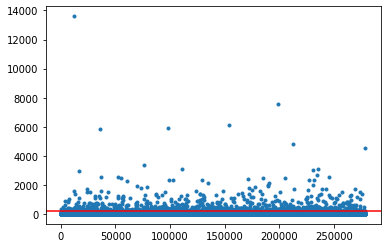

In [56]:
# Plot user vs rating count | red line is rating count = 200
plt.axhline(y = 200, color = 'r', linestyle = '-')
plt.scatter(df_ratings['user'].value_counts().index, df_ratings['user'].value_counts(), marker='.')

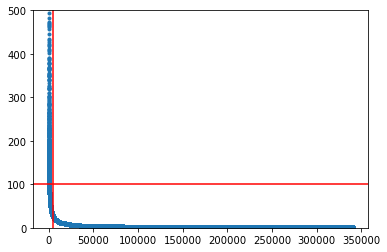

In [25]:
# Plot isbn vs rating count | horizontal red line is rating count = 100 | vertical red line are the 5000 books more times rated
x = df_ratings['isbn'].value_counts().index
y = df_ratings['isbn'].value_counts()
plt.axhline(y = 100, color = 'r', linestyle = '-')
plt.axvline(x= 5000, color= 'r', linestyle= '-')
plt.ylim(0, 500)
plt.scatter(range(len(x)), y, marker='.')

<AxesSubplot:>

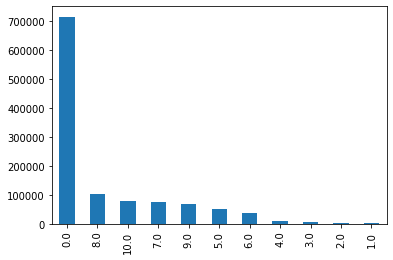

In [9]:
# Plot rating values vs value count
df_ratings.rating.value_counts(sort=True).plot(kind='bar')

# Data prepare
3 different ways
1. users>200ratings -> books>100ratings
2. books>100ratings -> users>200ratings
3. (users>200ratings & books>100ratings)

## **Data prepare #1**
- 1st: take ratings from users that rated more than 199 times
- 2nd: from 1st dataFame take books that where rated more than 99 times

Result: 13,793 len dataset -> 1.2% from total ratings. Remain: 857 books and users \n\n\n
SQL result: 13,802 len dataset -> 1.2% from total ratings

In [13]:
# Get the users that rated more than 200 times
users_more200ratings= pd.DataFrame((df_ratings['user'].value_counts() >= 200)) # heads: index=user, user=[bool]
users_more200ratings.reset_index(inplace=True)
users_more200ratings.rename(columns={'index':'user','user':'bool_index'}, inplace=True) # heads: index=index, user=user, bool_index=[bool]
users_more200ratings # +105k users
# users_more200ratings['bool_index'].value_counts() # 104,378 false users; 905 true users

,user,bool_index
0,11676,True
1,198711,True
2,153662,True
3,98391,True
4,35859,True
...,...,...
105278,116180,False
105279,116166,False
105280,116154,False
105281,116137,False


In [15]:
# Get ratings where users rated more than 200 times (cross users_more200ratings with df_ratings)
df_ratings_users = df_ratings[df_ratings['user'].isin(users_more200ratings['user'].where(users_more200ratings['bool_index']==True))]
df_ratings_users.info() # 527,556 ratings where users rated more than 200 times

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527556 entries, 1456 to 1147616
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   user    527556 non-null  int32  
 1   isbn    527556 non-null  object 
 2   rating  527556 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 12.1+ MB


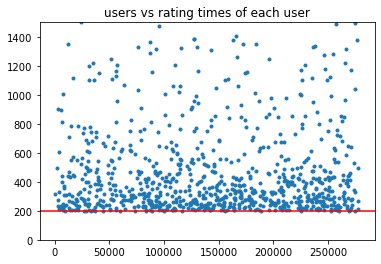

In [16]:
# Checking that dataset kept correct users | horizontal red line is rating count = 200
plt.axhline(y = 200, color = 'r', linestyle = '-')
plt.title("users vs rating times of each user")
plt.ylim((0,1500))
plt.scatter(df_ratings_users['user'].value_counts().index, df_ratings_users['user'].value_counts(), marker='.')

In [18]:
# Get books that were rated more than 100 times from df_ratings_users
isbn_more100ratings = pd.DataFrame(df_ratings_users['isbn'].value_counts() >= 100) # heads: index=isbn, isbn=[bool]
isbn_more100ratings.reset_index(inplace=True)
isbn_more100ratings.rename(columns={'index':'isbn','isbn':'bool_index'}, inplace=True) # heads: index=index, isbn=isbn, bool_index=[bool]
# isbn_more100ratings['bool_index'].value_counts() # 100 books that were rated more than 100 times
isbn_more100ratings.head()

,isbn,bool_index
0,0971880107,True
1,0316666343,True
2,0060928336,True
3,0440214041,True
4,0385504209,True


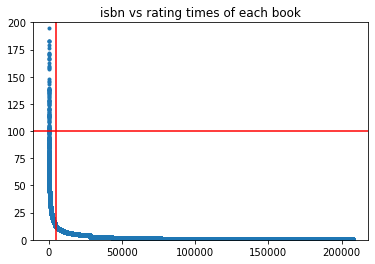

In [19]:
# Plot books vs rating times of each one, before apply the filter | horizontal red line is isbn count = 100 | vertical red line are the 5000 books more times rated
x = df_ratings_users['isbn'].value_counts().index
y = df_ratings_users['isbn'].value_counts()
plt.axhline(y = 100, color = 'r', linestyle = '-')
plt.axvline(x= 5000, color= 'r', linestyle= '-')
plt.ylim(0, 200)
plt.title("isbn vs rating times of each book")
plt.scatter(range(len(x)), y, marker='.')

In [20]:
# Get ratings where books were rate more than 100 times from df_ratings_users (cross isbn_more100ratings with df_ratings_users)
df_ratings_isbn = df_ratings_users[df_ratings_users['isbn'].isin(isbn_more100ratings['isbn'].where(isbn_more100ratings['bool_index']==True))]
# df_ratings_isbn.info() # 13,793 ratings where users rated more than 200 times and books where rate more than 100 times
df_ratings_isbn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13793 entries, 1469 to 1146988
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    13793 non-null  int32  
 1   isbn    13793 non-null  object 
 2   rating  13793 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 323.3+ KB


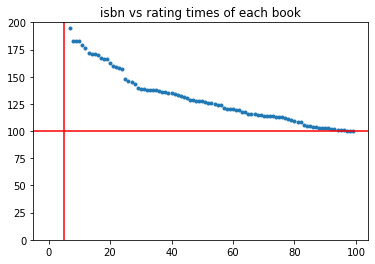

In [21]:
# Checking that dataset kept correct books | horizontal red line is isbn count = 100 | vertical red line are the 5000 books more times rated
x = df_ratings_isbn['isbn'].value_counts().index
y = df_ratings_isbn['isbn'].value_counts()
plt.axhline(y = 100, color = 'r', linestyle = '-')
plt.axvline(x= 5, color= 'r', linestyle= '-')
plt.ylim(0, 200)
plt.title("isbn vs rating times of each book")
plt.scatter(range(len(x)), y, marker='.')

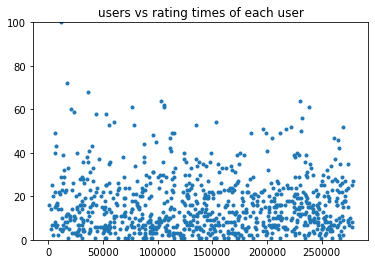

In [26]:
# Takeing out the books makes the correct users have less ratings done but doen't matter b
plt.axhline(y = 200, color = 'r', linestyle = '-')
plt.title("users vs rating times of each user")
plt.ylim((0,100))
plt.scatter(df_ratings_isbn['user'].value_counts().index, df_ratings_isbn['user'].value_counts(), marker='.')

## **Data prepare #2**

- 1st from 1st dataFame take books that where rate more than 99 times
- 2nd take ratings from users that rated more than 199 times 

Result: 5588 len dataset -> 0.5% from total ratings. Remind: 21 users and 731 books \n\n\n
SQL result: 5589 len dataset -> 0.5% from total ratings

In [ ]:
# Get books that were rate more than 100 times 
isbn_more100ratings_2 = pd.DataFrame(df_ratings['isbn'].value_counts() >= 100)
isbn_more100ratings_2.reset_index(inplace=True)
isbn_more100ratings_2.rename(columns={'index':'isbn','isbn':'bool_index'}, inplace=True)
isbn_more100ratings_2['bool_index'].value_counts() # 731 books that were rate more than 100 times
# isbn_more100ratings_2.head()

In [ ]:
# Get ratings where books were rate more than 100 times
df_ratings_isbn_2 = df_ratings[df_ratings['isbn'].isin(isbn_more100ratings_2['isbn'].where(isbn_more100ratings_2['bool_index']==True))]
df_ratings_isbn_2.info() # 138461 ratings where books were rate more than 100 times # sql result: 138537 (dif=76)

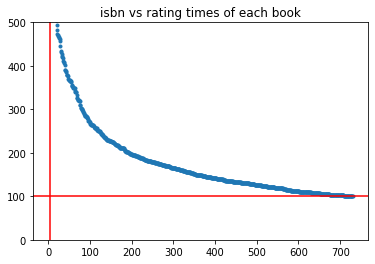

In [38]:
# Checking that dataset kept correct books
x = df_ratings_isbn_2['isbn'].value_counts().index
y = df_ratings_isbn_2['isbn'].value_counts()
plt.axhline(y = 100, color = 'r', linestyle = '-')
plt.axvline(x= 5, color= 'r', linestyle= '-')
plt.ylim(0, 500)
plt.title("isbn vs rating times of each book")
plt.scatter(range(len(x)), y, marker='.')

In [40]:
# Get the users than rated more than 200 times from df_ratings_isbn_2
users_more200ratings_2= pd.DataFrame((df_ratings_isbn_2['user'].value_counts() >= 200))
users_more200ratings_2.reset_index(inplace=True)
users_more200ratings_2.rename(columns={'index':'user','user':'bool_index'}, inplace=True)
# users_more200ratings_2['bool_index'].value_counts() # 32691 false users; 21 true users
users_more200ratings_2.head() # +105k users

,user,bool_index
0,11676,True
1,35859,True
2,16795,True
3,76352,True
4,60244,True


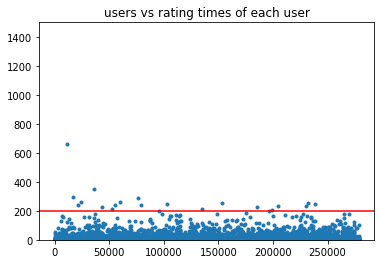

In [44]:
# Plot users vs rating times of each one, before apply the filter
plt.axhline(y = 200, color = 'r', linestyle = '-')
plt.title("users vs rating times of each user")
plt.ylim((0,1500))
plt.scatter(df_ratings_isbn_2['user'].value_counts().index, df_ratings_isbn_2['user'].value_counts(), marker='.')

In [41]:
# Get ratings where user rated more than 200 times from df_ratings_isbn_2
df_ratings_users_2 = df_ratings_isbn_2[df_ratings_isbn_2['user'].isin(users_more200ratings_2['user'].where(users_more200ratings_2['bool_index']==True))]
df_ratings_users_2.info() # 5588 ratings where books where rate more than 100 times and users rated more than 200 times
# df_ratings_isbn.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5588 entries, 45462 to 990631
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    5588 non-null   int32  
 1   isbn    5588 non-null   object 
 2   rating  5588 non-null   float32
dtypes: float32(1), int32(1), object(1)
memory usage: 131.0+ KB


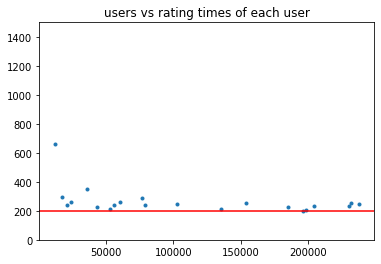

In [42]:
# Checking that dataset kept correct users
plt.axhline(y = 200, color = 'r', linestyle = '-')
plt.title("users vs rating times of each user")
plt.ylim((0,1500))
plt.scatter(df_ratings_users_2['user'].value_counts().index, df_ratings_users_2['user'].value_counts(), marker='.')

In [49]:
print(len(df_ratings_users_2['user'].unique()), len(df_ratings_users_2['isbn'].unique()))

21 731


## **Data prepare #3**

- from 1st dataFame take books that where rate more than 99 times
- take ratings from users that rated more than 199 times 
- Apply both to dataset

Result: 49781 len dataset -> 4.3% from total ratings. Remain: 731 bokks and 888 users. 37141 rating=0 -> 74% \n\n\n
SQL results: 49810 len dataset -> 4.3% from total ratings

In [27]:
# Get the users than rated more than 200 times
users_more200ratings_3= pd.DataFrame((df_ratings['user'].value_counts() >= 200))
users_more200ratings_3.reset_index(inplace=True)
users_more200ratings_3.rename(columns={'index':'user','user':'bool_index'}, inplace=True)
users_more200ratings_3 # +105k users
# users_more200ratings['bool_index'].value_counts() # 104,378 false users; 905 true users
user_index= users_more200ratings_3[users_more200ratings_3['bool_index'] ==True]
user_index.info() # 905

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 0 to 904
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   user        905 non-null    int64
 1   bool_index  905 non-null    bool 
dtypes: bool(1), int64(1)
memory usage: 15.0 KB


In [28]:
# Get books that were rated more than 100 times 
isbn_more100ratings_3 = pd.DataFrame(df_ratings['isbn'].value_counts() >= 100)
isbn_more100ratings_3.reset_index(inplace=True)
isbn_more100ratings_3.rename(columns={'index':'isbn','isbn':'bool_index'}, inplace=True)
isbn_more100ratings_3['bool_index'].value_counts() # 731 books that were rated more than 100 times
isbn_more100ratings_3.head()
# isbn_more100ratings_3.info() # 340,556 books in whole dataset
isbn_index= isbn_more100ratings_3[isbn_more100ratings_3['bool_index'] ==True]
isbn_index.info() # 731

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   isbn        731 non-null    object
 1   bool_index  731 non-null    bool  
dtypes: bool(1), object(1)
memory usage: 12.1+ KB


### Final rating dataset

dataset_clean

In [29]:
# Apply filter to dataset -> dataset_clean
dataset_clean = df_ratings[df_ratings['user'].isin(user_index['user']) & df_ratings['isbn'].isin(isbn_index['isbn'])]
dataset_clean.info() # 49781 ratings within users that rated >200 times & books that were rated >100 times
dataset_clean.reset_index(inplace=True)
dataset_clean.drop(columns=['index'], inplace=True)
dataset_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49781 entries, 1456 to 1147441
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    49781 non-null  int32  
 1   isbn    49781 non-null  object 
 2   rating  49781 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 1.1+ MB


c:\Users\pedro\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,user,isbn,rating
0,277427,002542730X,10.0
1,277427,0060930535,0.0
2,277427,0060934417,0.0
3,277427,0061009059,9.0
4,277427,0140067477,0.0


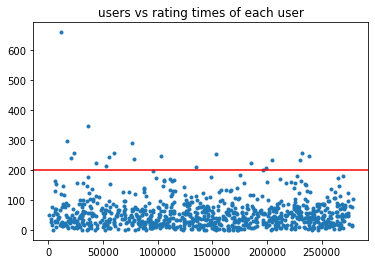

In [30]:
# Plot usres vs rating timnes of final dataset | horizontal line: 200 rating times
plt.axhline(y = 200, color = 'r', linestyle = '-')
plt.title("users vs rating times of each user")
plt.scatter(dataset_clean['user'].value_counts().index, dataset_clean['user'].value_counts(), marker='.')

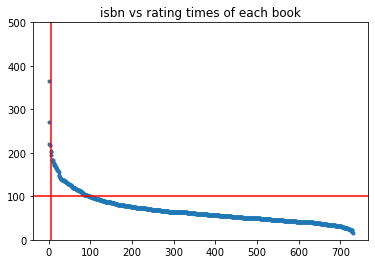

In [31]:
# Plot isbn vs rating times
# Really interesting how the curve kept a similar shape => the datapoints takken out were uniform distribuited
x = dataset_clean['isbn'].value_counts().index
y = dataset_clean['isbn'].value_counts()
plt.axhline(y = 100, color = 'r', linestyle = '-')
plt.axvline(x= 5, color= 'r', linestyle= '-')
plt.ylim(0, 500)
plt.title("isbn vs rating times of each book")
plt.scatter(range(len(x)), y, marker='.')


In [32]:
df_ratings_cero = dataset_clean.loc[dataset_clean['rating'] == 0]
df_ratings_cero
df_ratings_cero['isbn'].value_counts()

0971880107    327
0060928336    170
0316666343    167
0440214041    164
0440222656    153
             ... 
0316781142     13
0091867770     12
0451191145     12
039592720X     11
0671027344     11
Name: isbn, Length: 731, dtype: int64

## Merge one dataset

In [33]:
# Merge dataset_clean & books title
dataset_merge_rating_titles = pd.merge(dataset_clean.assign(x=dataset_clean.isbn.astype(str)), 
        df_books.assign(x=df_books.isbn.astype(str)), 
        how='inner', on='x').copy()
dataset_merge_rating_titles.drop(columns=['x', 'isbn_y', 'author'], inplace=True)
dataset_merge_rating_titles.rename(columns={'isbn_x':'isbn'}, inplace=True)
dataset_merge_rating_titles.head()

,user,isbn,rating,title
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...


In [34]:
# Convert table (dataset_merge_rating_title) into 2-D matrix: index = 'title', columns = 'user', values = 'rating'
dataset = dataset_merge_rating_titles.copy()
dataset.drop_duplicates(['user', 'title'], inplace=True)
dataset_pivot = dataset.pivot(index = 'title', columns = 'user', values = 'rating').fillna(0)
dataset_sparse_matrix = csr_matrix(dataset_pivot.values) # Easier to compute
dataset_pivot.head(10)

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Case of Need,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A Child Called \It\"": One Child's Courage to Survive""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Civil Action,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model KNN

Hyperparameters:
- Metric = cosine: messure the distance between 2 points with the angle of both vectors, this way the modules don't count (contrary to euclidean distance). This has a lot of sense since we are working with not-number data (https://cmry.github.io/notes/euclidean-v-cosine)
- Algorithm = brute: inefficient with huge dataset, but ours is not too big

In [35]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(dataset_sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

## Testing model

In [36]:
query_index = np.random.choice(dataset.shape[0])
aux = dataset_pivot.index.tolist()
query_index = aux.index("The Queen of the Damned (Vampire Chronicles (Paperback))")
distances, indices = model_knn.kneighbors(dataset_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(dataset_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, dataset_pivot.index[indices.flatten()[len(distances.flatten())-i]], distances.flatten()[len(distances.flatten())-i]))

Recommendations for The Queen of the Damned (Vampire Chronicles (Paperback)):

1: Catch 22, with distance of 0.793983519077301:
2: The Witching Hour (Lives of the Mayfair Witches), with distance of 0.7448656558990479:
3: Interview with the Vampire, with distance of 0.7345068454742432:
4: The Tale of the Body Thief (Vampire Chronicles (Paperback)), with distance of 0.5376338362693787:
5: The Vampire Lestat (Vampire Chronicles, Book II), with distance of 0.5178411602973938:


# **Recommendation func**

In [38]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  aux = dataset_pivot.index.tolist()
  query_index = aux.index(book)
  distances, indices = model_knn.kneighbors(dataset_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)

  recommended_books = []
  recommended_books.append(book)
  recommended_books.append(list())
  for i in range(1, len(distances.flatten())):
    # if i == 0:
    #     print('Recommendations for {0}:\n'.format(dataset_pivot.index[query_index]))
    # else:
    #     print('{0}: {1}, with distance of {2}:'.format(i, dataset_pivot.index[indices.flatten()[len(distances.flatten())-i]], distances.flatten()[len(distances.flatten())-i]))
    
    recommended_books[1].append([dataset_pivot.index[indices.flatten()[len(distances.flatten())-i]], distances.flatten()[len(distances.flatten())-i]])
  return recommended_books

# Aplication/Test
Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [39]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
